In [1]:
from hurst import *

In [2]:
import pandas as pd
import numpy as np

import talib
from scipy import stats
# import statsmodels.api as sm 


import functools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as mg # 不规则子图
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')
# 中文显示
plt.rcParams['font.family'] = 'serif'

# 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False



In [3]:
import re
def To_time(date):
    # from time import time
    import time
    dt_lst = []
    p = re.compile('[\u4e00-\u9fa5]')
    for dt in date:
        dt = p.split(dt)
        if len(dt[1])==1:
            dt[1] = '0'+dt[1]
        if len(dt[2])==1:
            dt[2] = '0'+dt[2]
        dt_lst.append(pd.to_datetime(dt[0]+'-'+dt[1]+'-'+dt[2]))
    return dt_lst

In [4]:
cyb = pd.read_csv(r'C:\Users\Administrator\Desktop\cyb.csv',index_col=0).iloc[::-1,:]

# eval(cyb.iloc[2,0])
for c in cyb.columns:
    cyb[c] = cyb[c].str.replace(',','')
# cyb.replace(',','',inplace = True)
cyb.index = To_time(cyb.index)
cyb


,收盘,开盘,高,低,交易量,涨跌幅
2010-06-02,997.12,967.61,997.12,952.61,107.50M,2.45%
2010-06-03,998.39,1002.36,1026.70,997.77,161.70M,0.13%
2010-06-04,1027.68,989.68,1027.68,986.50,150.00M,2.93%
2010-06-07,1069.47,1005.03,1075.22,1001.70,265.50M,4.07%
2010-06-08,1067.15,1067.32,1075.50,1050.96,197.70M,-0.22%
...,...,...,...,...,...,...
2022-04-29,2319.14,2247.70,2322.97,2221.99,2.37B,4.11%
2022-05-05,2288.40,2263.92,2317.17,2242.96,1.72B,-1.33%
2022-05-06,2244.97,2227.68,2274.28,2223.82,13.86K,-1.90%
2022-05-09,2228.07,2236.17,2263.01,2213.58,11.42K,-0.75%


In [5]:
rtn = cyb.iloc[:,1].apply(lambda x:pd.to_numeric(x))
rtn = rtn.pct_change().dropna()
close = cyb.iloc[:,0].apply(lambda x:pd.to_numeric(x))
cyb = cyb.iloc[:,:4].apply(lambda x:pd.to_numeric(x))
cyb.columns = ['close','open','high','low']
cyb

,close,open,high,low
2010-06-02,997.12,967.61,997.12,952.61
2010-06-03,998.39,1002.36,1026.70,997.77
2010-06-04,1027.68,989.68,1027.68,986.50
2010-06-07,1069.47,1005.03,1075.22,1001.70
2010-06-08,1067.15,1067.32,1075.50,1050.96
...,...,...,...,...
2022-04-29,2319.14,2247.70,2322.97,2221.99
2022-05-05,2288.40,2263.92,2317.17,2242.96
2022-05-06,2244.97,2227.68,2274.28,2223.82
2022-05-09,2228.07,2236.17,2263.01,2213.58


In [6]:
# Standardization(Z-score normalization)
def Standardization(ser: pd.Series, rolling: bool = False,
                    N: int = None) -> pd.Series:

    if rolling:
        
        return (ser - ser.rolling(N).mean()) / ser.rolling(N).std()
    
    else:
        
        return (ser - ser.mean()) / ser.std()

# Mean normalization
def MeanNormalization(ser: pd.Series, rolling: bool = False,
                      N: int = None) -> pd.Series:

    if rolling:

        (ser - ser.rolling(N).mean()) / (
            ser.rolling(N).max() - ser.rolling(N).min())

    else:

        return (ser - ser.mean()) / (ser.max() - ser.min())

# Rescaling (min-max normalization) 有时简称normalization
def Rescaling(ser: pd.Series, rolling: bool = False,
              N: int = None) -> pd.Series:

    if rolling:

        return (ser - ser.rolling(N).min()) / (
            ser.rolling(N).max() - ser.rolling(N).min())

    else:

        return (ser - ser.min()) / (ser.max() - ser.min())

# Scaling to unit length
def ScalingToUnitLength(ser: pd.Series, rolling: bool = False,
                        N: int = None) -> pd.Series:

    if rolling:
        return ser / ser.rolling(N).apply(
            lambda x: np.linalg.norm(x), raw=False)
    else:
        return ser / np.linalg.norm(ser)


# 费雪变换
def FisherTransform(standar_Ser: pd.Series) -> pd.Series:

    return 0.5 * np.log((1 + standar_Ser) / (1 - standar_Ser))


# 显示分布
def ShowDisplot(ser: pd.Series, rolling: bool = False, N: int = None):

    fig = plt.figure(figsize=(12, 16))
    
    fig.add_subplot(4,2,1)
    plt.title('原始数据分布')
    sns.distplot(ser.dropna(),kde=False,axlabel=False)
    
    fig.add_subplot(4, 2, 2)
    plt.title('MeanNormalization')
    sns.distplot(MeanNormalization(ser, rolling, N), kde=False, axlabel=False)
    
    fig.add_subplot(4,2,3)
    plt.title('原始数据分布')
    sns.distplot(ser.dropna(),kde=False,axlabel=False)
    
    fig.add_subplot(4, 2, 4)
    plt.title('Rescaling')
    sns.distplot(Rescaling(ser, rolling, N), kde=False, axlabel=False)

    fig.add_subplot(4,2,5)
    plt.title('原始数据分布')
    sns.distplot(ser.dropna(),kde=False,axlabel=False)
    
    fig.add_subplot(4, 2, 6)
    plt.title('ScalingToUnitLength')
    sns.distplot(ScalingToUnitLength(ser, rolling, N), kde=False, axlabel=False)
    
    fig.add_subplot(4,2,7)
    plt.title('原始数据分布')
    sns.distplot(ser.dropna(),kde=False,axlabel=False)
    
    fig.add_subplot(4, 2, 8)
    plt.title('Standardization')
    sns.distplot(Standardization(ser, rolling, N), kde=False, axlabel=False)
    
# 比较变换前后的数据分布
def CompareDistribution(ser:pd.Series,scaling_func,method:str):
    '''
    比较变换前后的数据分布
    transform_func：为归一化的处理函数
    method:hist、bar 两种图表显示方式
    -------------------------
    plot
    '''
    
    standar_pctchg = scaling_func(ser)
    frisher_pct = FisherTransform(standar_pctchg)
    frisher_pct = frisher_pct.replace(np.inf, np.nan)
        
    if method == 'bar':
        
        c = ser.to_frame('v')
        c['name'] = '费雪变换前'
        s = frisher_pct.to_frame('v')
        s['name'] = '费雪变换后'

        con_df = pd.concat([c,s])
        con_df['g'] = pd.cut(con_df['v'],10)

        con_df = con_df.groupby('name')['g'].apply(lambda x:x.value_counts())
        con_df = con_df.reset_index()

        con_df.columns = ['name','x','y']
        plt.figure(figsize=(8,5))
        plt.title('费雪变换前后数据分布')
        sns.barplot(x='x',y='y',data=con_df,hue='name')
        plt.xlabel('')
        plt.ylabel('')
        x_labe = con_df['x'].values.categories.right
        plt.xticks(range(len(x_labe)),x_labe) # ,rotation=90
        plt.show()
        
    elif method == 'hist':
        
        
        fig = plt.figure(figsize=(18, 6))
        fig.add_subplot(1, 3, 1)
        plt.title('变换前涨跌幅分布')
        sns.distplot(ser, bins=10, kde=False)

        fig.add_subplot(1, 3, 2)
        plt.title('变换后涨跌幅分布')
        sns.distplot(frisher_pct.dropna(), bins=10, kde=False)

        fig.add_subplot(1, 3, 3)
        plt.title('对比')
        sns.distplot(ser, bins=10, kde=False, color='r')
        sns.distplot(frisher_pct.dropna(), bins=10, kde=False)
        plt.legend(['变换前', '变换后'])

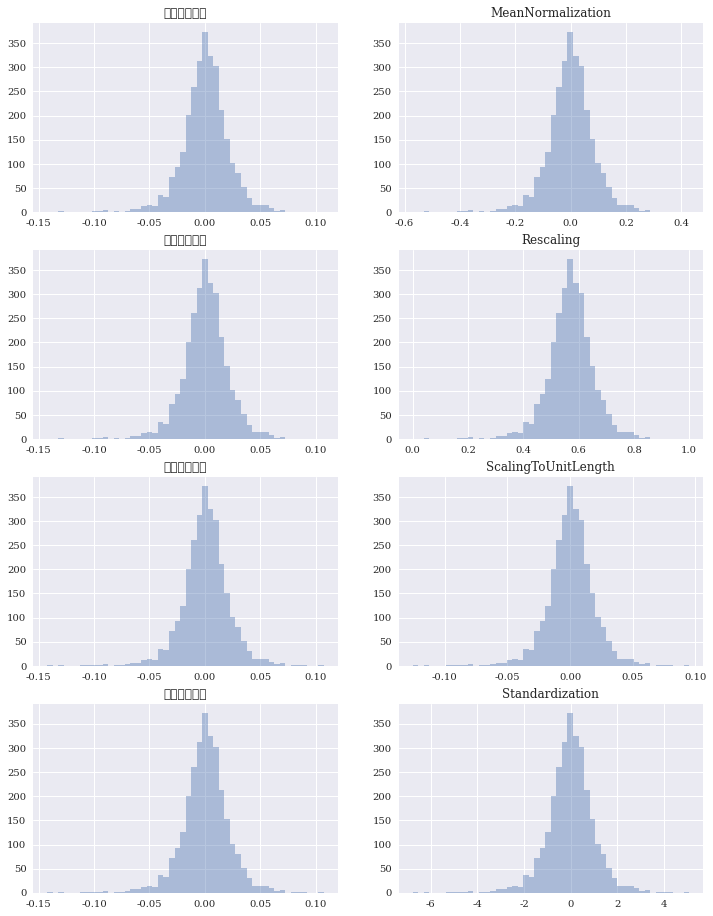

In [7]:
ShowDisplot(rtn)

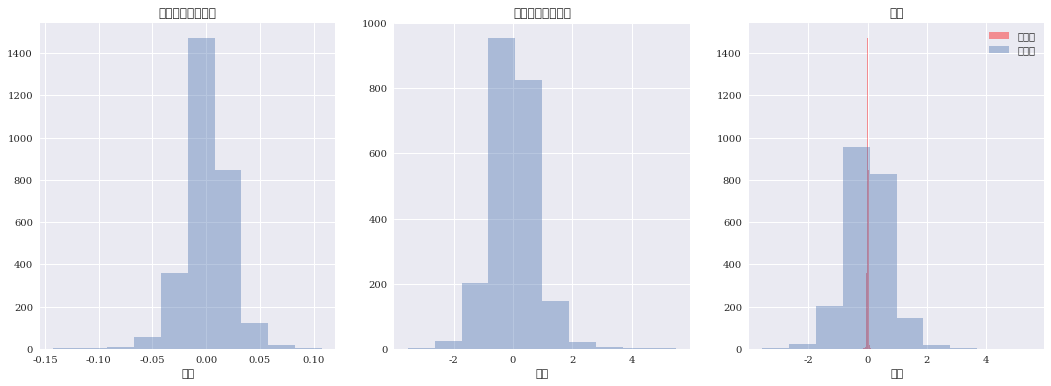

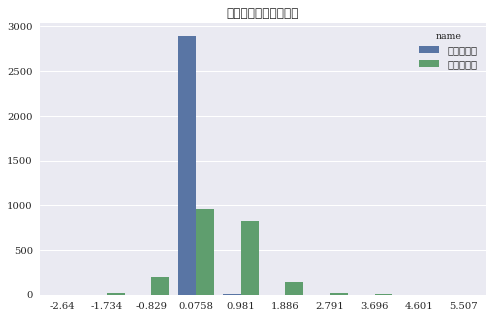

In [8]:
CompareDistribution(rtn,Standardization,'hist')
CompareDistribution(rtn,Standardization,'bar')

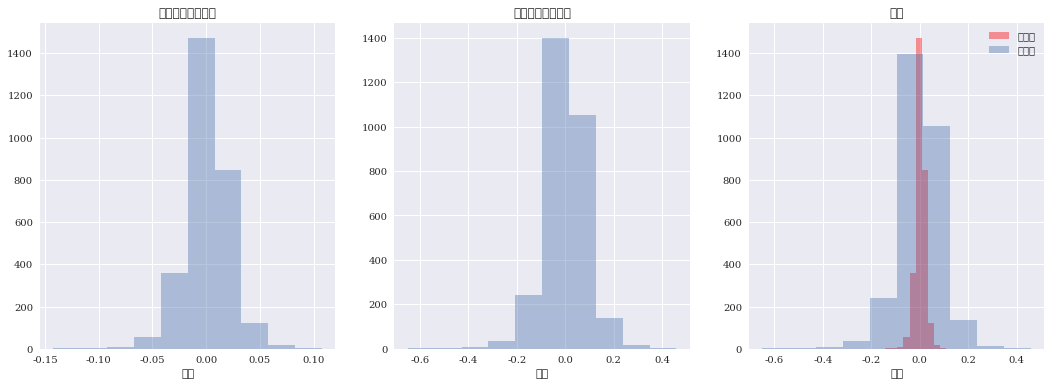

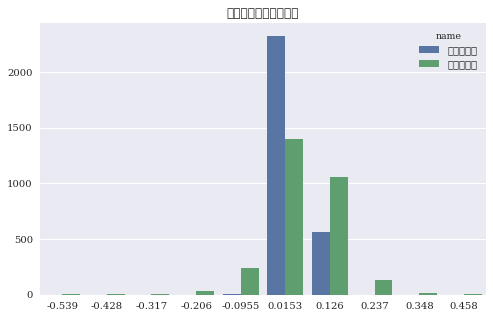

In [9]:
CompareDistribution(rtn,MeanNormalization,'hist')
CompareDistribution(rtn,MeanNormalization,'bar')

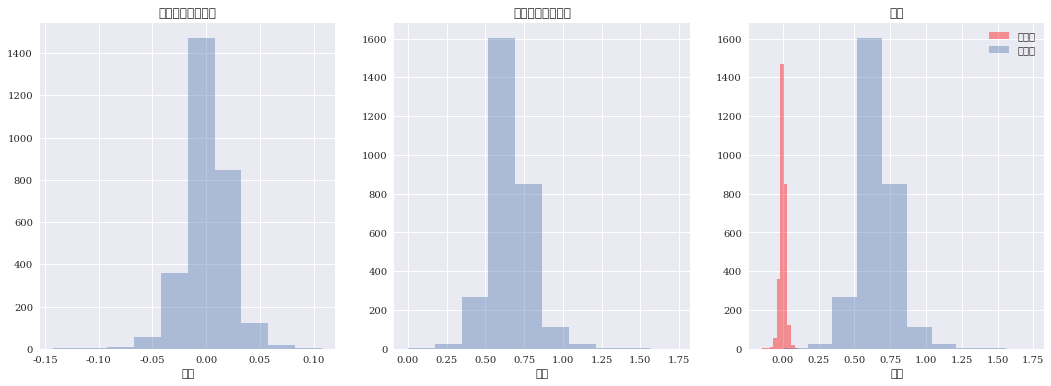

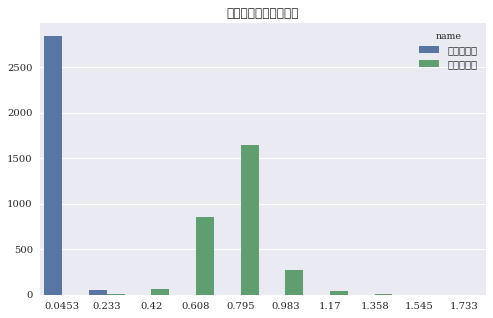

In [10]:
CompareDistribution(rtn,Rescaling,'hist')
CompareDistribution(rtn,Rescaling,'bar')

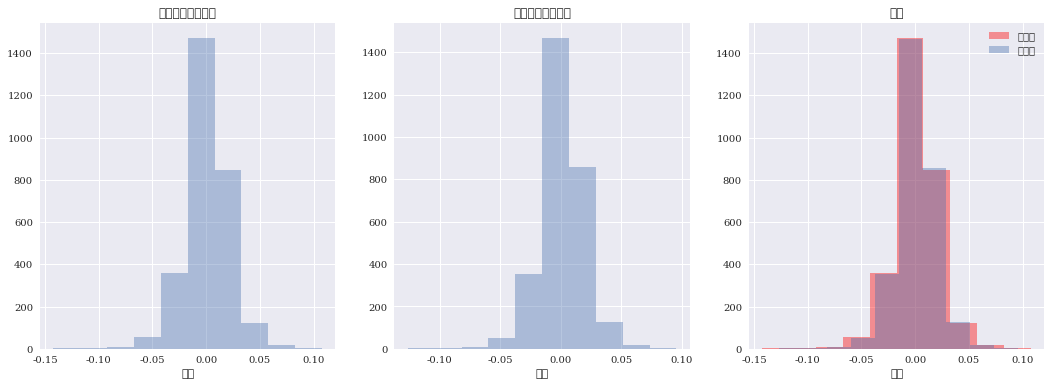

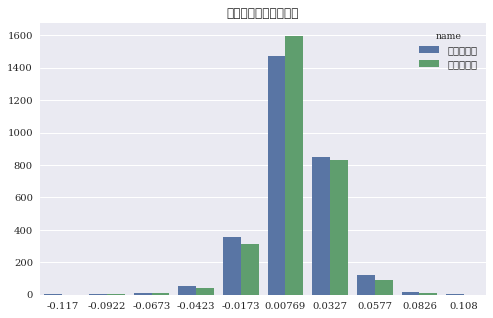

In [11]:
CompareDistribution(rtn,ScalingToUnitLength,'hist')
CompareDistribution(rtn,ScalingToUnitLength,'bar')

In [12]:
standar_pctchg = ScalingToUnitLength(rtn)
frisher_pct = FisherTransform(standar_pctchg)
frisher_pct = frisher_pct.replace(np.inf, np.nan).fillna(method='ffill')
frisher_pct = frisher_pct.dropna()

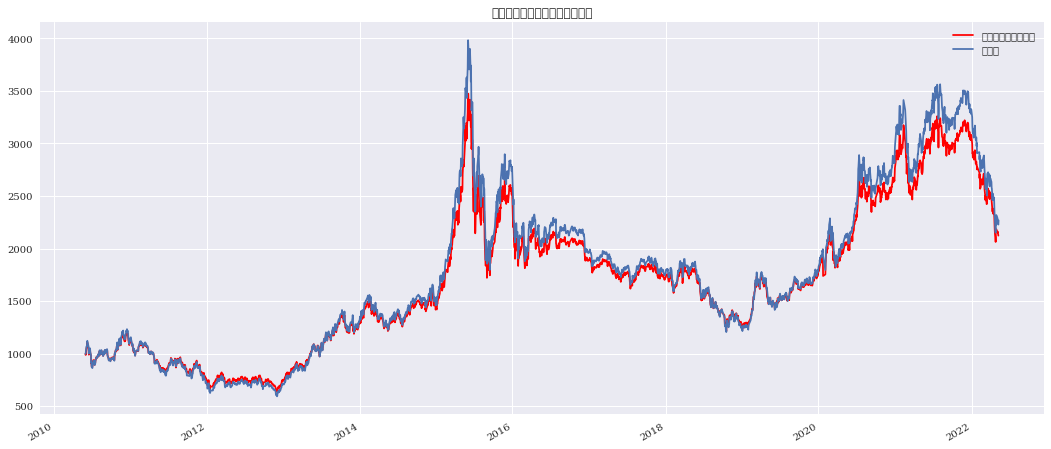

In [13]:
c = [0] * len(frisher_pct)

c[0] = close.reindex(frisher_pct.index)[0]
for i, e in enumerate(frisher_pct[1:]):

    c[i + 1] = c[i] * (1 + e)

# 模拟指数数据
simulation_cyb = pd.Series(c, index=close.index[:-1])
simulation_cyb.plot(color='r', title='费雪变换模拟扩板后的创业板指')
close.plot(figsize=(18, 8))
plt.legend(['费雪变换模拟创业板', '创业板'])

In [14]:
def VolatilityTest(df_1: pd.DataFrame, df_2: pd.DataFrame) -> pd.DataFrame:

    # Hurst
    H, c, data = compute_Hc(df_1['close'], kind='price', simplified=True)
    s_H, s_c, s_data = compute_Hc(df_2['close'].dropna(), kind='price', simplified=True)

    # 日均ATR 研报给出的计算窗口为14日
    atr = np.mean(talib.ATR(df_1['high'], df_1['low'], df_1['close'], 14))
    atr_s = np.mean(talib.ATR(df_2['high'], df_2['low'], df_2['close'], 14))

    # 峰度
    kurtosis = stats.kurtosis(df_1['close'].pct_change().dropna())
    kurtosis_s = stats.kurtosis(df_2['close'].pct_change().dropna())

    # 波动率
    vol = np.std(df_1['close'].pct_change()) * np.sqrt(244)
    vol_s = np.std(df_2['close'].pct_change()) * np.sqrt(244)

    return pd.DataFrame(
        [[vol, vol_s], [atr, atr_s], [kurtosis, kurtosis_s], [H, s_H]],
        index=['波动率', '日均ATR', '峰度', 'Hurst'],
        columns=['基准', '比较值'])

In [15]:
df_1 = cyb[['close','high','low']].copy()
df_2 = df_1.copy()
df_2['close'] = simulation_cyb

print(VolatilityTest(df_1,df_2))
print('*基准为原始创业板指,比较值为费雪变换后创业板指')

              基准         比较值
波动率     0.306489    0.290221
日均ATR  44.050930  101.216864
峰度      1.759274    3.982787
Hurst   0.757476    0.723261
*基准为原始创业板指,比较值为费雪变换后创业板指


In [16]:
def Cal_OLSTL(arr):

    size = len(arr)  # N
    weights = np.array([i - (size + 1) / 3 for i in range(1, size + 1)])  # 权重
    avg = weights * arr
    constant = 6 / (size * (size + 1))  # 参数项
    return constant * np.sum(avg)

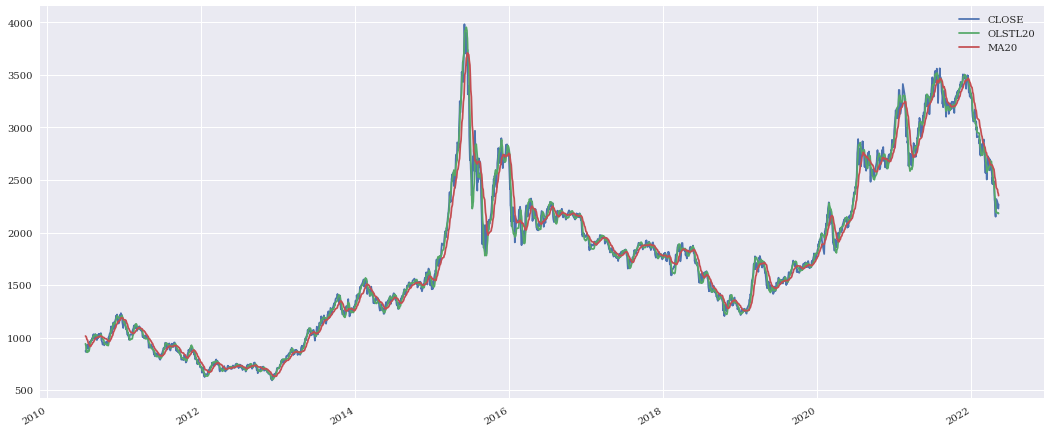

In [17]:
ma20 = cyb.rolling(20)['close'].apply(Cal_OLSTL, raw=False)
df = pd.concat([cyb['close'], ma20, cyb['close'].rolling(20).mean()], axis=1)
df.columns = ['CLOSE', 'OLSTL20', 'MA20']
df.dropna().plot(figsize=(18, 8))

In [18]:
def backtest(n, plot=False):

    ma20 = cyb.rolling(n)['close'].apply(Cal_OLSTL, raw=False)

    cond = ma20.diff() > 0
    next_ret = cyb['close'].pct_change().shift(-1)

    cum = (1 + next_ret * cond).cumprod()

    if plot:
        return (cum.iloc[-2])
    else:
        cum.plot(figsize=(18, 8))
        (cyb.close / cyb.close[0]).plot()

In [19]:
cum = {}
for i in range(10, 100, 10):
    cum[i] = backtest(i, True)

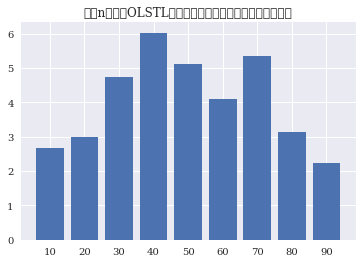

In [20]:
plt.title('不同n参数下OLSTL多头择时策略累积收益率（创业板指）')
plt.bar(range(9), cum.values())
plt.xticks(range(9), range(10, 100, 10))
plt.show()

In [21]:
from bt import *

# cyb.index = To_time(cyb.index)
olstl_40 = simulation_cyb.rolling(40).apply(Cal_OLSTL, raw=False)  # 计算OLSTL
cond = olstl_40.diff() > 0  # 差分
next_ret = rtn.shift(-1)  # 指数本身的收益


In [25]:
cond

2010-06-02    False
2010-06-03    False
2010-06-04    False
2010-06-07    False
2010-06-08    False
              ...  
2022-04-28    False
2022-04-29    False
2022-05-05    False
2022-05-06    False
2022-05-09    False
Length: 2897, dtype: bool

            benchmark  algorithm_cum
2010-06-02   1.000000       1.000000
2010-06-03   1.001274       1.000000
2010-06-04   1.030648       1.000000
2010-06-07   1.072559       1.000000
2010-06-08   1.070232       1.000000
...               ...            ...
2022-04-27   2.275724      11.509861
2022-04-28   2.234084      11.509861
2022-04-29   2.325838      11.509861
2022-05-05   2.295010      11.509861
2022-05-06   2.251454      11.509861

[2896 rows x 2 columns]


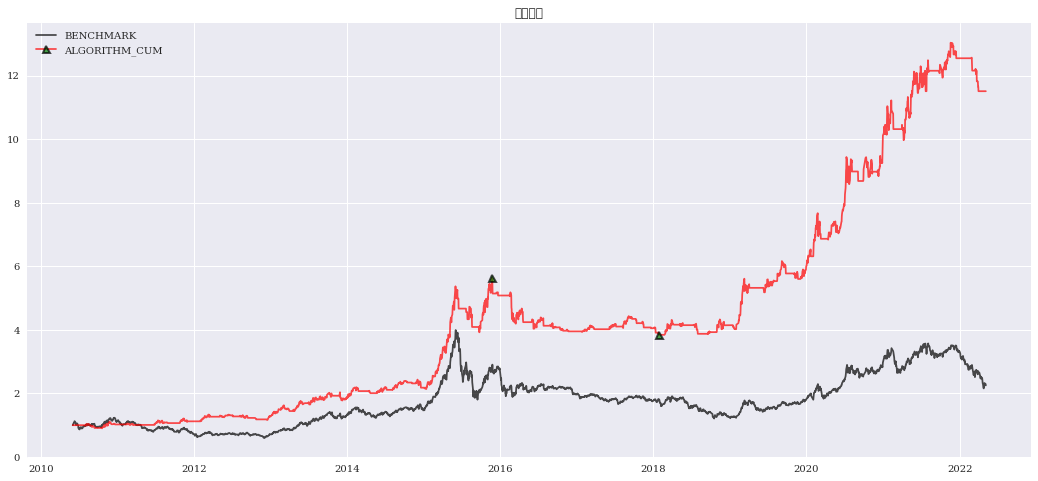

风险指标
                     algorithm_cum  benchmark
annual_return             0.236980   0.073200
return_volatility         0.212557   0.311583
sharpe_ratio              0.069758   0.024147
max_drawdown             -0.316578  -0.697400
relative_return           0.163780   0.000000
relative_volatility      -0.099026   0.000000
relative_drawdown         0.380822   0.000000
info_ratio                0.439652        NaN
trade_count             128.000000        NaN
win_count                60.000000        NaN
win_ratio                 0.468800        NaN
分年度风险指标
      annual_return  return_volatility  sharpe_ratio  max_drawdown  \
2010       0.041164           0.236024      0.018139     -0.133206   
2011       0.099890           0.157375      0.043082     -0.089970   
2012       0.139525           0.157538      0.057187     -0.128053   
2013       0.484336           0.267987      0.101360     -0.128449   
2014       0.150051           0.185261      0.053389     -0.104578   
2015       1.40

In [23]:

# 回测指标分析模块
bt = BackTest(cyb.close,cond * 1)

# 净值画图
bt.plot_algorithm_cum()

# 风险指标
bt.GetRisk

            algorithm_cum    maxhere  ddpercent
2010-06-02       1.000000   1.000000   0.000000
2010-06-03       1.000000   1.000000   0.000000
2010-06-04       1.000000   1.000000   0.000000
2010-06-07       1.000000   1.000000   0.000000
2010-06-08       1.000000   1.000000   0.000000
...                   ...        ...        ...
2022-04-27      11.509861  13.036603   0.117112
2022-04-28      11.509861  13.036603   0.117112
2022-04-29      11.509861  13.036603   0.117112
2022-05-05      11.509861  13.036603   0.117112
2022-05-06      11.509861  13.036603   0.117112

[2896 rows x 3 columns]
平均回撤(ADD):10.84%
线性加权回撤(lwDD):9.81%
均方回撤(ADD^2):2.20%
最大回撤开始时间范围:20151124-20180129


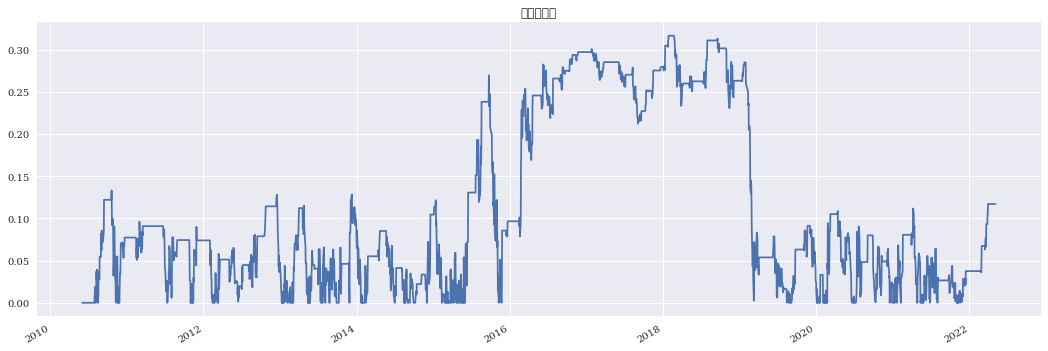

In [24]:
bt.plot_ddpercent()